<ipython-input-1-84377b578ecf>:8: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  sentiment_analysis_results = pd.read_csv(sentiment_analysis_file)


Sentiment distribution saved to: /content/Sentiment_By_Topic_Percentage.csv
Visualization saved to: /content/Topic_Sentiment_Distribution.png


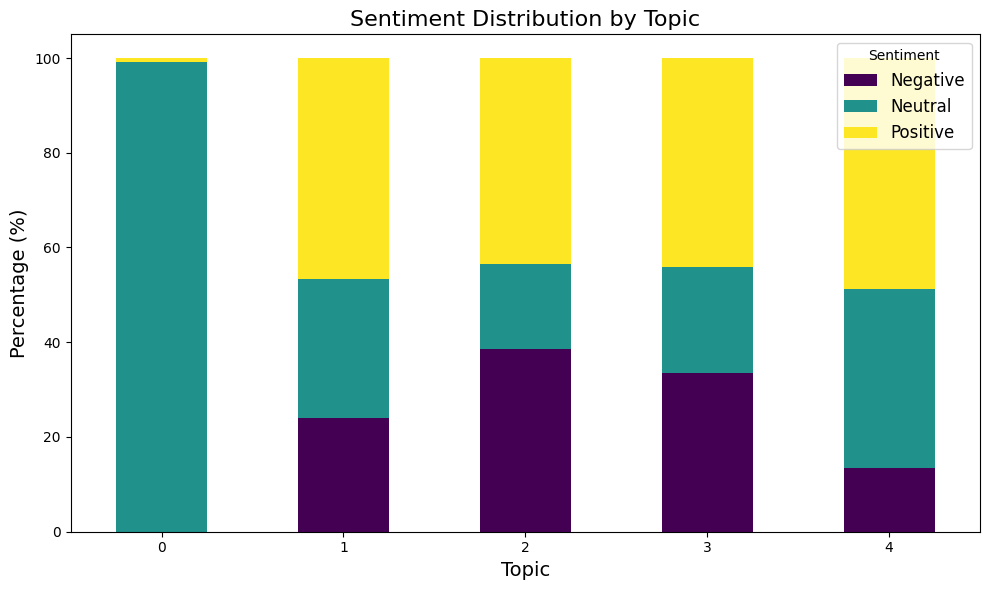

Results saved to: /content/Topic_Sentiment_Analysis_Results.csv


In [1]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

# Step 1: Load Sentiment Analysis Results
sentiment_analysis_file = '/content/Sentiment_Analysis_Results.csv'
sentiment_analysis_results = pd.read_csv(sentiment_analysis_file)

# Handle missing or invalid values in the Processed_Review column
sentiment_analysis_results['Processed_Review'] = sentiment_analysis_results['Processed_Review'].fillna("")

# Step 2: Perform Topic Modeling
vectorizer = CountVectorizer(max_features=1000, stop_words='english')
review_matrix = vectorizer.fit_transform(sentiment_analysis_results['Processed_Review'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)  # 5 topics
lda.fit(review_matrix)

# Extract the top words for each topic
def get_topic_keywords(model, feature_names, n_top_words=10):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        topics[topic_idx] = ", ".join(top_words)
    return topics

# Get the topic keywords
feature_names = vectorizer.get_feature_names_out()
topic_keywords = get_topic_keywords(lda, feature_names)

# Assign a topic name and description
topic_names = {
    0: "E-Commerce Services",
    1: "Delivery Issues",
    2: "Product Quality",
    3: "Customer Support",
    4: "Pricing and Offers"
}

topic_descriptions = {
    0: "Discussions about general e-commerce services and satisfaction.",
    1: "Complaints about delayed or failed deliveries.",
    2: "Feedback related to the quality of purchased products.",
    3: "Interactions with customer support and issue resolutions.",
    4: "Comments on pricing, discounts, and promotional offers."
}

# Assign topics to reviews
sentiment_analysis_results['Topic'] = lda.transform(review_matrix).argmax(axis=1)
sentiment_analysis_results['Topic Name'] = sentiment_analysis_results['Topic'].map(topic_names)
sentiment_analysis_results['Topic Description'] = sentiment_analysis_results['Topic'].map(topic_descriptions)

# Step 3: Aggregate Sentiments by Topic
sentiment_by_topic = sentiment_analysis_results.groupby(['Topic', 'Sentiment']).size().unstack(fill_value=0)
sentiment_by_topic_percentage = sentiment_by_topic.div(sentiment_by_topic.sum(axis=1), axis=0) * 100

# Add Topic Names and Descriptions to Sentiment Percentages
sentiment_by_topic_percentage.reset_index(inplace=True)
sentiment_by_topic_percentage['Topic Name'] = sentiment_by_topic_percentage['Topic'].map(topic_names)
sentiment_by_topic_percentage['Topic Description'] = sentiment_by_topic_percentage['Topic'].map(topic_descriptions)

# Reorder columns for better readability
columns = ['Topic', 'Topic Name', 'Topic Description'] + [col for col in sentiment_by_topic_percentage.columns if col not in ['Topic', 'Topic Name', 'Topic Description']]
sentiment_by_topic_percentage = sentiment_by_topic_percentage[columns]

# Save the updated sentiment distribution file
sentiment_by_topic_percentage_path = '/content/Sentiment_By_Topic_Percentage.csv'
sentiment_by_topic_percentage.to_csv(sentiment_by_topic_percentage_path, index=False)
print(f"Sentiment distribution saved to: {sentiment_by_topic_percentage_path}")

# Step 4: Visualization: Sentiment Distribution by Topic
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each sentiment's percentage for every topic
sentiment_by_topic_percentage.set_index('Topic').iloc[:, 2:].plot(kind='bar', stacked=True, ax=ax, colormap='viridis')

# Add labels and title
plt.title("Sentiment Distribution by Topic", fontsize=16)
plt.xlabel("Topic", fontsize=14)
plt.ylabel("Percentage (%)", fontsize=14)
plt.xticks(rotation=0)
plt.legend(title="Sentiment", fontsize=12)
plt.tight_layout()

# Save and display the visualization
visualization_path = '/content/Topic_Sentiment_Distribution.png'
plt.savefig(visualization_path)
print(f"Visualization saved to: {visualization_path}")

plt.show()

# Save Updated Sentiment Analysis Results
output_file_path = '/content/Topic_Sentiment_Analysis_Results.csv'
sentiment_analysis_results.to_csv(output_file_path, index=False)
print(f"Results saved to: {output_file_path}")
